# Task: Eres un analista de datos y tu mánager quiere entender mejor el panorama de las keywords. Te ha pedido que prepares un pequeño informe respondiendo a las siguientes preguntas.

1) El crecimiento interanual (yoy_change) es útil, pero quiero una categoría simple: 'Crecimiento', 'Declino' o 'Estable'.
2) Ahora, ¿la competencia es diferente para las keywords que están en crecimiento vs. las que están en declino?
3) Dame un resumen. ¿Cuál es el promedio de avg_monthly_searches y la mediana de competition_index para cada grupo de tendencia?
4) Necesito una lista de 'joyas ocultas': keywords que tengan más de 1000 búsquedas mensuales pero que, por alguna razón, tengan una competencia 'Low'"

In [13]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf

# --- Configuraciones de buenas prácticas ---
# Configurar SQL
pysqldf = lambda q: sqldf(q, globals())
# Configura Seaborn para que los gráficos se vean más modernos
sns.set_theme(style="whitegrid")
# Evita que salgan números en notación científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Librerías importadas y configuraciones aplicadas.")

Librerías importadas y configuraciones aplicadas.


In [14]:
# 2. Cargar el DataFrame LIMPIO
# Le decimos que entre a la carpeta 'basic_analytics' y busque el archivo
# ".." significa "subir un nivel" (a la carpeta PYTHON-DATA-ANALYTICS)
# Luego, bajamos a "basic_analytics"
ruta_archivo = "../basic_analytics/data_google_ads_clean.csv"

df_limpio = pd.read_csv(ruta_archivo)

print("Datos limpios cargados. ¡Listo para el análisis!")

# 3. Inspección rápida
print(df_limpio.info())
print(df_limpio.head())
print(df_limpio.tail())


Datos limpios cargados. ¡Listo para el análisis!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Keyword                   376 non-null    object 
 1   Currency                  376 non-null    object 
 2   avg_monthly_searches      376 non-null    float64
 3   three_month_change        350 non-null    float64
 4   yoy_change                346 non-null    float64
 5   Competition               376 non-null    object 
 6   competition_index         240 non-null    float64
 7   bid_low                   110 non-null    float64
 8   bid_high                  110 non-null    float64
 9   Ad impression share       0 non-null      float64
 10  Organic impression share  0 non-null      float64
 11  Organic average position  0 non-null      float64
 12  In account?               0 non-null      float64
 13  In plan?        

In [15]:
# 4. Categorizar el crecimiento interanual
def categorizar_crecimiento(valor):
    if valor > 0.05:
        return 'Crecimiento'
    elif valor < -0.05:
        return 'Declino'
    elif -0.05 <= valor <= 0.05:
        return 'Estable'
    else:
        return 'Desconocido'

df_limpio['tendencia'] = df_limpio['yoy_change'].apply(categorizar_crecimiento)
print("Categorías de tendencia asignadas.")

Categorías de tendencia asignadas.


In [16]:
# 5. Análisis de competencia por categoría de tendencia
consulta_competencia = """
SELECT competition, COUNT(*) as cantidad, tendencia
FROM df_limpio
GROUP BY competition, tendencia
ORDER BY competition, cantidad DESC
"""
df_competencia = pysqldf(consulta_competencia)
print("Análisis de competencia por categoría de tendencia realizado.")
print(df_competencia)

Análisis de competencia por categoría de tendencia realizado.
   Competition  cantidad    tendencia
0         High        14      Estable
1         High         5  Desconocido
2         High         3  Crecimiento
3         High         1      Declino
4          Low        90      Estable
5          Low        36      Declino
6          Low        17  Desconocido
7          Low        16  Crecimiento
8       Medium        31      Estable
9       Medium        10  Crecimiento
10      Medium         9      Declino
11      Medium         8  Desconocido
12     Unknown        95      Estable
13     Unknown        41      Declino


In [17]:
# 6. Resumen estadístico por grupo de tendencia
# sqlite no tiene la función MEDIAN, por lo que calculamos la mediana usando pandas directamente.
df_resumen = (
    df_limpio
    .groupby('tendencia')
    .agg(
        promedio_busquedas_mensuales=('avg_monthly_searches', 'mean'),
        mediana_indice_competencia=('competition_index', 'median')
    )
    .reset_index()
)

# Aseguramos un orden lógico de las categorías y reordenamos el resultado
ordered = ['Crecimiento', 'Declino', 'Estable', 'Desconocido']
df_resumen['tendencia'] = pd.Categorical(df_resumen['tendencia'], categories=ordered, ordered=True)
df_resumen = df_resumen.sort_values('tendencia').reset_index(drop=True)

print("Resumen estadístico por grupo de tendencia realizado.")
print(df_resumen)

Resumen estadístico por grupo de tendencia realizado.
     tendencia  promedio_busquedas_mensuales  mediana_indice_competencia
0  Crecimiento                        339.31                       29.00
1      Declino                         77.01                       17.00
2      Estable                        111.57                       16.00
3  Desconocido                         11.33                       21.50


In [18]:
# 7. Identificación de 'joyas ocultas'
joyas_ocultas = df_limpio[(df_limpio['avg_monthly_searches'] > 1000) & (df_limpio['Competition'] == 'Low')]
print("Identificación de 'joyas ocultas' realizada.")
print(joyas_ocultas)

Identificación de 'joyas ocultas' realizada.
                           Keyword Currency  avg_monthly_searches  \
1                 sector economico      ARS               2400.00   
2              sectores economicos      ARS               2400.00   
14  banco de servicios financieros      ARS               2900.00   
17   servicio financiero carrefour      ARS               5400.00   

    three_month_change  yoy_change Competition  competition_index  bid_low  \
1               -19.00        0.00         Low               0.00    10.59   
2               -19.00        0.00         Low               0.00    10.59   
14                0.00       21.00         Low              26.00     3.61   
17                0.00        0.00         Low              32.00     3.60   

    bid_high  Ad impression share  ...  Searches: Oct 2022  \
1      76.88                  NaN  ...             2400.00   
2      76.88                  NaN  ...             2400.00   
14     51.22                  Na

In [19]:
# 8. Resultados finales
print("\n--- Resumen Final ---")
print("Análisis de competencia por categoría de tendencia:")
print(df_competencia)

print("\nResumen estadístico por grupo de tendencia:")
print(df_resumen)

print("\nJoyas ocultas:")
print(joyas_ocultas)


--- Resumen Final ---
Análisis de competencia por categoría de tendencia:
   Competition  cantidad    tendencia
0         High        14      Estable
1         High         5  Desconocido
2         High         3  Crecimiento
3         High         1      Declino
4          Low        90      Estable
5          Low        36      Declino
6          Low        17  Desconocido
7          Low        16  Crecimiento
8       Medium        31      Estable
9       Medium        10  Crecimiento
10      Medium         9      Declino
11      Medium         8  Desconocido
12     Unknown        95      Estable
13     Unknown        41      Declino

Resumen estadístico por grupo de tendencia:
     tendencia  promedio_busquedas_mensuales  mediana_indice_competencia
0  Crecimiento                        339.31                       29.00
1      Declino                         77.01                       17.00
2      Estable                        111.57                       16.00
3  Desconocido    

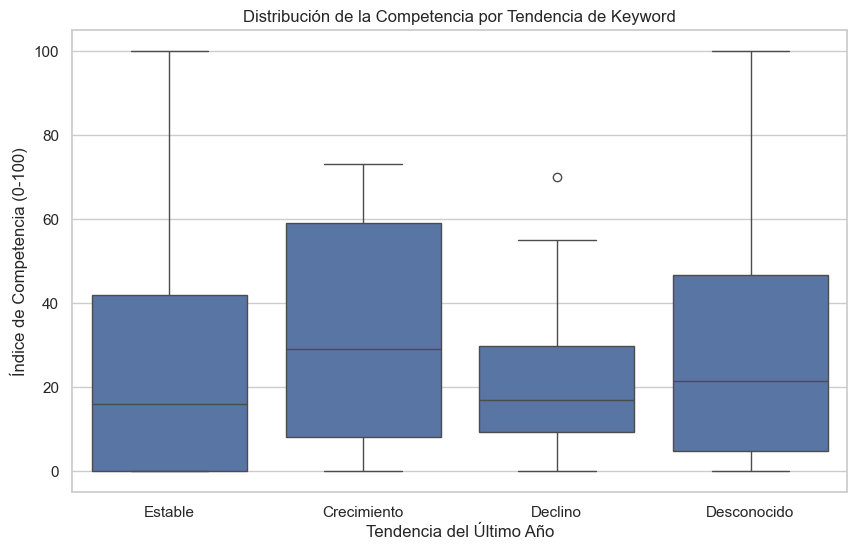

In [20]:
# 9. Visualización de los resultados
# Gráfico de caja para visualizar la distribución del índice de competencia por tendencia

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_limpio, x='tendencia', y='competition_index')

plt.title('Distribución de la Competencia por Tendencia de Keyword')
plt.xlabel('Tendencia del Último Año')
plt.ylabel('Índice de Competencia (0-100)')
plt.show()

